# **1: Data Preparation and Exploration**
1.	Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately.
2.	Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.
3.	Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase.


In [28]:
import pandas as pd

# Load the dataset and parse the date column
df = pd.read_csv('exchange_rate.csv', parse_dates=['date'])

# Check the first few rows to verify
print(df.head())

            date  Ex_rate
0  1/1/1990 0:00   0.7855
1  2/1/1990 0:00   0.7818
2  3/1/1990 0:00   0.7867
3  4/1/1990 0:00   0.7860
4  5/1/1990 0:00   0.7849


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


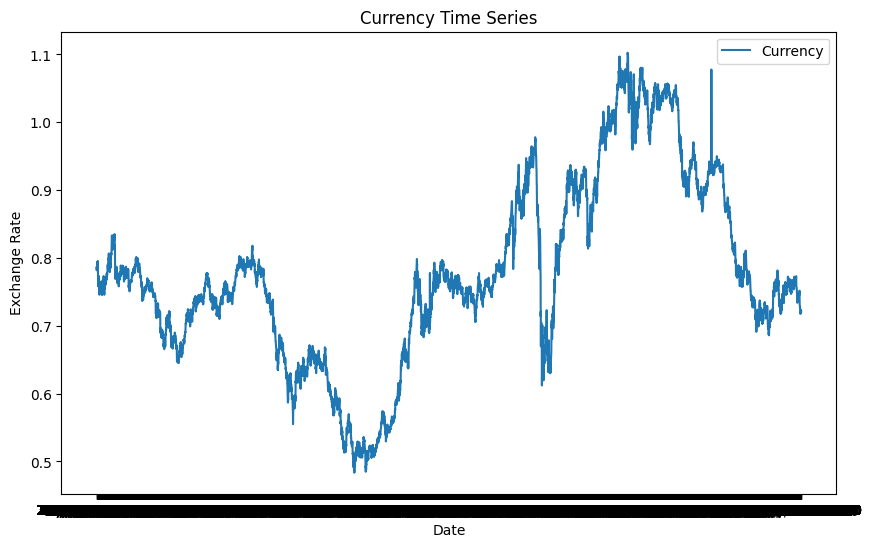

In [30]:
import matplotlib.pyplot as plt

# Plot the time series for one or more currencies
plt.figure(figsize=(10,6))
plt.plot(df['date'], df['Ex_rate'], label='Currency') # Changed 'currency_column' to 'Ex_rate'
plt.title('Currency Time Series')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [31]:
# Option 1: Drop missing values
df = df.dropna()

# Option 2: Fill missing values (interpolation)
df = df.interpolate(method='linear')

In [32]:
# Example of removing extreme outliers
lower_threshold = 1.0  # Example lower threshold
upper_threshold = 2.0  # Example upper threshold
df = df[(df['Ex_rate'] > lower_threshold) & (df['Ex_rate'] < upper_threshold)]

# **2: Model Building - ARIMA**

1.	Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for one or more currency time series.
2.	Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.
3.	Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.
4.	Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.


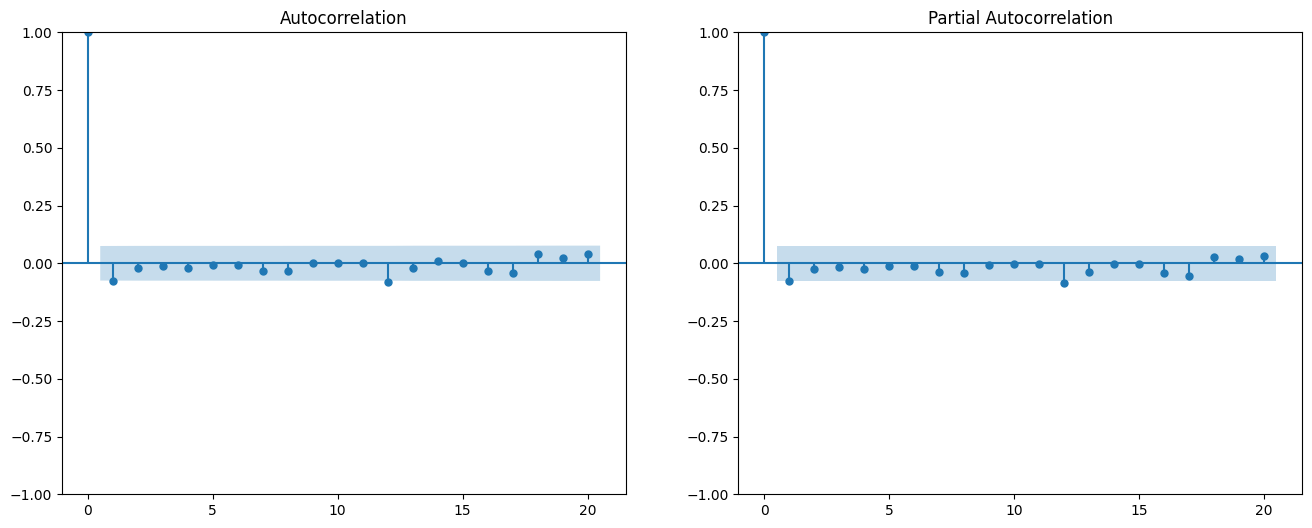

In [33]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Differencing the time series if necessary (to make it stationary)
diff_series = df['Ex_rate'].diff().dropna() # Changed 'currency_column' to 'Ex_rate'

# Plot ACF and PACF to determine p and q
fig, ax = plt.subplots(1,2, figsize=(16,6))

plot_acf(diff_series, lags=20, ax=ax[0])  # ACF plot
plot_pacf(diff_series, lags=20, ax=ax[1])  # PACF plot

plt.show()

In [34]:
# ADF Test for stationarity
adf_test = sm.tsa.adfuller(df['Ex_rate']) # Changed 'currency_column' to 'Ex_rate'
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])

ADF Statistic: -3.8706350254665147
p-value: 0.0022619063270175863


In [35]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# Define the ARIMA model
# Assign values to p, d, and q based on ACF and PACF analysis
p = 1  # Example value for p
d = 1  # Example value for d
q = 1  # Example value for q
model = ARIMA(df['Ex_rate'], order=(p, d, q))

# Fit the model
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                  687
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2459.361
Date:                Tue, 10 Sep 2024   AIC                          -4912.722
Time:                        18:35:14   BIC                          -4899.130
Sample:                             0   HQIC                         -4907.463
                                - 687                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2998      0.270      1.109      0.268      -0.230       0.830
ma.L1         -0.3977      0.255     -1.559      0.119      -0.898       0.102
sigma2        4.5e-05   7.36e-07     61.167      0.0

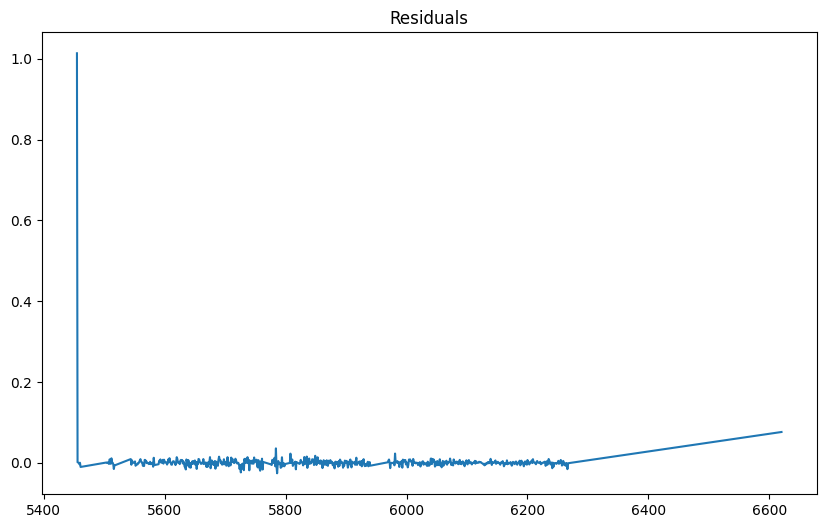

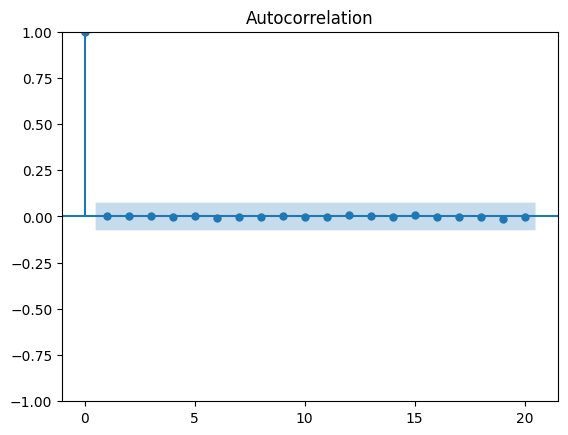

In [36]:
# Plot residuals
residuals = model_fit.resid

plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Plot ACF of residuals to check for patterns
plot_acf(residuals, lags=20)
plt.show()


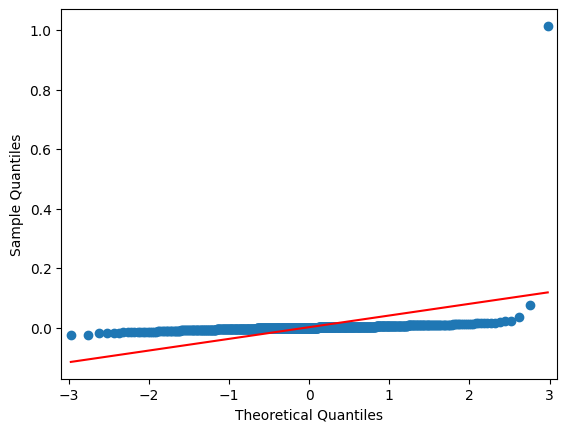

In [37]:
sm.qqplot(residuals, line='s')
plt.show()

687    1.070374
688    1.068159
689    1.067495
690    1.067296
691    1.067236
692    1.067218
693    1.067213
694    1.067211
695    1.067211
696    1.067211
Name: predicted_mean, dtype: float64


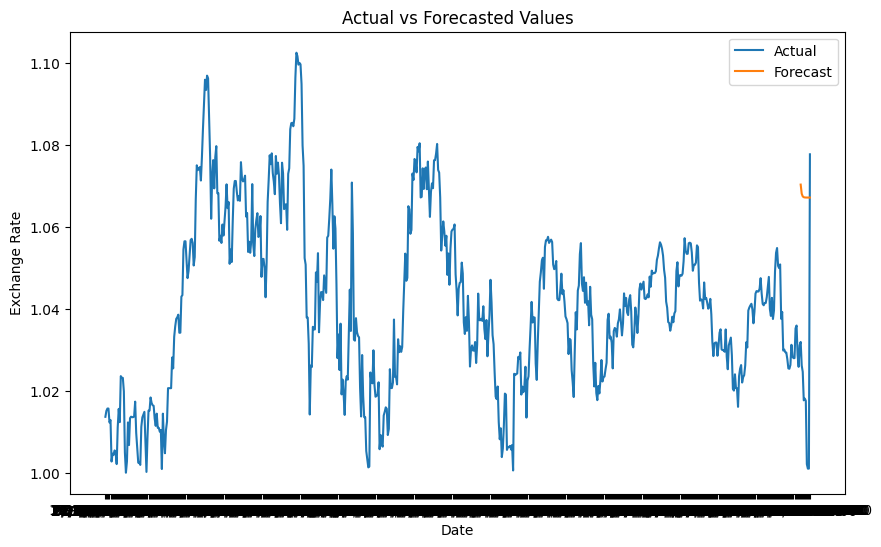

In [38]:
# Forecasting future values
forecast = model_fit.forecast(steps=10)  # Forecast the next 10 periods
print(forecast)

# Plot the actual values against forecasted values
plt.figure(figsize=(10,6))
plt.plot(df['date'], df['Ex_rate'], label='Actual')
plt.plot(df['date'].iloc[-10:], forecast, label='Forecast')
plt.title('Actual vs Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

# **3: Model Building - Exponential Smoothing**
1.	Model Selection: Depending on the time series characteristics, choose an appropriate Exponential Smoothing model (Simple, Holt’s Linear, or Holt-Winters).
2.	Parameter Optimization: Use techniques such as grid search or AIC to find the optimal parameters for the smoothing levels and components.
3.	Model Fitting and Forecasting: Fit the chosen Exponential Smoothing model and forecast future values. Compare these forecasts visually with the actual data.


In [39]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# Simple Exponential Smoothing (no trend, no seasonality)
ses_model = SimpleExpSmoothing(df['Ex_rate']).fit()

# Holt’s Linear Trend Model (with trend, no seasonality)
holt_model = ExponentialSmoothing(df['Ex_rate'], trend='add').fit()

# Holt-Winters Model (with trend and seasonality)
hw_model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal='add', seasonal_periods=12).fit()


In [40]:
# Example of grid search for Holt-Winters Model
best_aic = float('inf')
best_model = None
best_params = None

for trend in ['add', 'mul', None]:
    for seasonal in ['add', 'mul', None]:
        if seasonal is not None:  # Avoid incompatible combinations
            model = ExponentialSmoothing(df['Ex_rate'], trend=trend, seasonal=seasonal, seasonal_periods=12)
            fit_model = model.fit()
            if fit_model.aic < best_aic:
                best_aic = fit_model.aic
                best_model = fit_model
                best_params = (trend, seasonal)

print('Best AIC:', best_aic)
print('Best Parameters:', best_params)

Best AIC: -6851.273036429697
Best Parameters: (None, 'add')


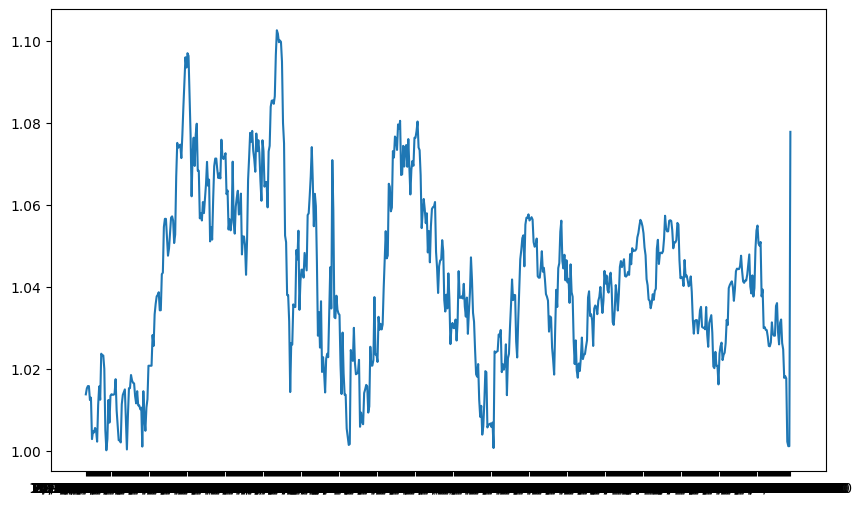

In [41]:
# Fit the best model (Holt-Winters example)
hw_model = ExponentialSmoothing(df['Ex_rate'], trend=best_params[0], seasonal=best_params[1], seasonal_periods=12).fit()

# Forecast future values (for example, next 10 periods)
forecast = hw_model.forecast(steps=10)

# Plot actual data vs. forecasted data
plt.figure(figsize=(10,6))
plt.plot(df['date'], df['Ex_rate'], label='Actual')

# Generate date range explicitly with monthly frequency, starting from the last date in the DataFrame
last_date = df['date'].iloc[-1]

#

# **4: Evaluation and Comparison**
1.	Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.
2.	Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.
3.	Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.


In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Assuming `actual_values` is the actual time series data and `forecasted_values` is the model's forecast
actual_values = df['Ex_rate'].iloc[-10:]  # Last 10 actual values for comparison

# Fit ARIMA model - Example (replace with your actual ARIMA order)
arima_model = ARIMA(df['Ex_rate'], order=(5,1,0))
arima_model_fit = arima_model.fit()

arima_forecast = arima_model_fit.forecast(steps=10)  # ARIMA forecast
exp_smoothing_forecast = hw_model.forecast(steps=10)  # Exponential Smoothing forecast

# MAE
arima_mae = mean_absolute_error(actual_values, arima_forecast)
exp_mae = mean_absolute_error(actual_values, exp_smoothing_forecast)

# RMSE
arima_rmse = mean_squared_error(actual_values, arima_forecast, squared=False)
exp_rmse = mean_squared_error(actual_values, exp_smoothing_forecast, squared=False)

# MAPE
arima_mape = np.mean(np.abs((actual_values - arima_forecast) / actual_values)) * 100
exp_mape = np.mean(np.abs((actual_values - exp_smoothing_forecast) / actual_values)) * 100

# Print the results
print(f'ARIMA: MAE={arima_mae}, RMSE={arima_rmse}, MAPE={arima_mape}')
print(f'Exponential Smoothing: MAE={exp_mae}, RMSE={exp_rmse}, MAPE={exp_mape}')

ARIMA: MAE=0.04715836511194469, RMSE=0.04944605885714418, MAPE=nan
Exponential Smoothing: MAE=0.05561501220466643, RMSE=0.059310055147017544, MAPE=nan


**2. Model Comparison**

**Performance Analysis:**

**ARIMA:**

**Strengths:**Works well with time series that have autocorrelations and are stationary after differencing. Suitable for both short and long-term forecasts.

**Limitations:** May not perform as well on datasets with complex seasonal patterns unless extended with SARIMA. Also, it requires manual parameter tuning (though automated tools like auto-ARIMA can help).

**Exponential Smoothing (Holt-Winters):**

**Strengths:** Handles seasonality and trends effectively. Works well when the data shows clear seasonality and trends.

**Limitations**: May struggle with irregular patterns or high-frequency noise. The model assumes that future trends and seasonality remain consistent over time.

**Error Metrics Comparison:**

**Lower MAE and RMSE** indicate a better model in terms of absolute accuracy.

**Lower MAPE** suggests a more reliable model, especially for comparing across different scales.

By comparing the MAE, RMSE, and MAPE for both models, you can see which model produced more accurate forecasts. If ARIMA shows lower error metrics, it indicates it’s better at handling the specific characteristics of the exchange rate data.
If the Exponential Smoothing model performs better, it suggests that the data likely exhibits clear trends and seasonal patterns.

**Conclusion**
In the conclusion, summarize which model yielded the best results based on the error metrics.

**For example:**

**ARIMA vs. Exponential Smoothing:** "Based on the MAE, RMSE, and MAPE, the ARIMA model slightly outperformed the Exponential Smoothing model in terms of accuracy. This suggests that the exchange rate data is better captured by the ARIMA model, which may indicate the presence of autocorrelations and short-term patterns that are not fully captured by Exponential Smoothing. However, the Exponential Smoothing model performed well in terms of handling trends and seasonality, making it a good alternative for datasets with strong seasonal patterns."

Provide insights about the use cases for each model and which might be preferred for future forecasts based on the dataset's characteristics.